 # 🔎 Deep Dive into Model Selection & Hyperparameter Tuning in Deep Learning

Welcome to this hands-on notebook where we explore the art and science of building performant deep learning models through **model selection**, **hyperparameter tuning**, and **regularization techniques**.

Using the classic **MNIST handwritten digits dataset**, we'll walk through a practical pipeline that mirrors real-world machine learning workflows. This notebook isn’t just about getting high accuracy—it’s about understanding the *why* behind each design choice.

---

### 🚀 How to Think Like a Good AI Engineer

- 📊 **Understand Your Data**: Analyze and **visualize data** to define our **machine learning problem**  
- ✂️ **Data Splitting**: Best practices for dividing data into training, validation, and test sets  
- ⚡ **Model Design**: How to define a neural network from scratch  
- 🧪 **Model Selection**: The impact of key **hyperparameters** like learning rate, batch size, and number of layers  
- 🛡️ **Regularization Techniques**: How to improve **generalization** using **Dropout** and **Early Stopping**
---
     


## 📊 Understand Your Data


The **MNIST dataset** is a collection of 70,000 grayscale images of handwritten digits (0–9), each sized 28×28 pixels. It is widely used as a benchmark for image classification tasks in machine learning.

In this notebook, we load a small **fraction** of the MNIST dataset to speed up experimentation and reduce training time, while still preserving meaningful insights.


#### ⏳ Loading MNIST dataset

In [12]:
import os
import wandb
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from torchvision import transforms, datasets
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np

In [13]:
def load_mnist(fraction=0.25):
    transform = transforms.ToTensor()
    mnist_train_full = datasets.MNIST(os.getcwd(), train=True, download=True, transform=transform)

    # Reduce training set if fraction < 1
    if 0 < fraction < 1.0:
        subset_size = int(fraction * len(mnist_train_full))
        mnist_train_full, _ = random_split(mnist_train_full, [subset_size, len(mnist_train_full) - subset_size])

    # Extract images and labels as tensors
    data = torch.stack([mnist_train_full[i][0] for i in range(len(mnist_train_full))])
    targets = torch.tensor([mnist_train_full[i][1] for i in range(len(mnist_train_full))])

    print(f"Loaded MNIST subset with {len(data):,} images.")
    print(f"Image tensor shape: {data.shape}")
    print(f"Labels tensor shape: {targets.shape}")

    return data, targets

In [14]:
images, targets = load_mnist(fraction=0.50)

Loaded MNIST subset with 30,000 images.
Image tensor shape: torch.Size([30000, 1, 28, 28])
Labels tensor shape: torch.Size([30000])


### 👀 Visualising MNIST dataset

In [15]:
def visualize_dataset_sample(idx=0):
    """This function visualizes a 
    single sample from the dataset by index."""    
    # Plot
    plt.figure(figsize=(3,3))
    
    image = images[idx].squeeze()
    label = targets[idx].item()
    
    plt.imshow(image, cmap='gray')
    plt.title(f"Lable={label}", fontsize=10)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


def plot_label_distribution(labels, title="Label Distribution"):
    """Plots a histogram of label counts to visualize class balance."""
    # Convert tensor to numpy for plotting
    label_array = labels.numpy()
    
    # Create histogram
    plt.figure(figsize=(8, 4))
    plt.hist(label_array, bins=range(11), align='left', rwidth=0.8, color='skyblue', edgecolor='black')
    
    # Add text and grid
    plt.title(title)
    plt.xlabel("Digit Label")
    plt.ylabel("Number of Samples")
    plt.xticks(range(10))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

#### Visualize one sample and the labels distribution

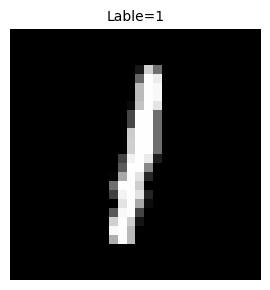

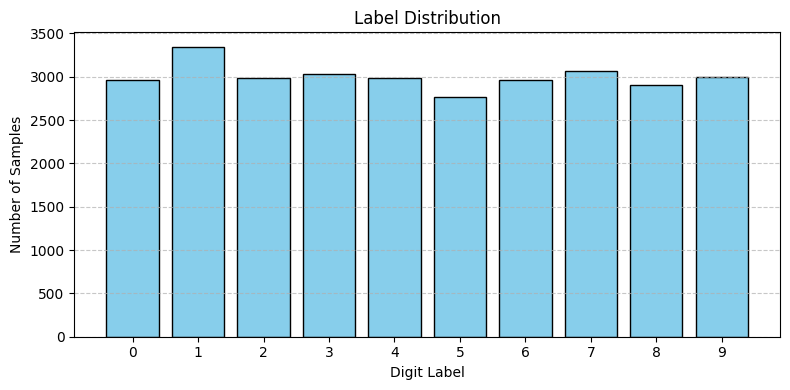

In [16]:
# visualize one sample
smaple_index = 6
visualize_dataset_sample(idx=smaple_index)
# Call the function on the full set or on splits
plot_label_distribution(targets)

## ✂️ Dataset Split: Making a Train/Validation set

**Proper data splitting** is essential to ensure that the model is trained and validated on **distinct, representative subsets** of the data. This helps to:
- 🔒 **prevent data leakage**
- ⚖️ **reduce overfitting**
- 📈 **produce reliable performance estimates**

We start with the available dataset. It’s important to realize that **this is all the data we have**, and we must **decide how to split it** into training and validation sets.

To do this, we use `sklearn.model_selection.train_test_split`, which provides a flexible way to divide the data while optionally maintaining label distribution using **stratification**.

🧠 **Key point:**  
Choosing the right split ratio (e.g., 80/20 or 70/30) is part of the design decisions **students must make**. This decision impacts training quality and validation reliability of the model selection proces.

Let’s now define our split!



In [17]:
# Define split ratio
validation_ratio = 0.25 # TODO 

# Perform the split with stratification to maintain label balance
X_train, X_val, y_train, y_val = train_test_split(images, targets, test_size=validation_ratio, stratify=targets, random_state=42)

# Set as TensorDatasets
ratio = 0.1  # reduce training data
train_dataset = TensorDataset(X_train[:int(len(X_train)*ratio)], y_train[:int(len(X_train)*ratio)])
val_dataset = TensorDataset(X_val, y_val)

# Check the size of the splits
print(f"Train set: {len(train_dataset)} samples")
print(f"Validation set: {len(val_dataset)} samples")

Train set: 2250 samples
Validation set: 7500 samples


## ⚡ Model Architecture

In this notebook, we use a **fully connected neural network (MLP)** to classify handwritten digits from the MNIST dataset.

### 🧠 Model Structure:
- The network starts by **flattening** the 28×28 input image.
- Then, it passes through one or more **hidden layers** with **ReLU activations**.
- Finally, it outputs **10 logits** (one for each digit class).

This structure is simple but effective for small image datasets like MNIST, and it allows us to explore the effect of **hyperparameters** such as:
- Number of **hidden units**
- Number of **layers**
- **Learning rate**
- **Optimizer** type (SGD or Adam).


In [23]:
# 1. Define the LightningModule
class LitMNIST(pl.LightningModule):
    def __init__(self, hidden=128, layers=2, lr=1e-3, dropout=0., optimizer='Adam'):
        super().__init__()
        # save hyperparameters
        self.save_hyperparameters()
        
        # set architecture
        model = [torch.nn.Flatten(),
                 torch.nn.Linear(28 * 28, hidden),
                 torch.nn.ReLU(),
                 torch.nn.Dropout(p=dropout)]  # Dropout after each ReLU
        
        for i in range(layers - 2):
            model.append(torch.nn.Linear(hidden, hidden))
            model.append(torch.nn.ReLU())
            model.append(torch.nn.Dropout(p=dropout))  # Dropout after each ReLU
    
        model.append(torch.nn.Linear(hidden, 10))  # Final output layer without dropout
        
        self.model = torch.nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        if self.hparams.optimizer == 'SGD':
            optimizer = torch.optim.SGD(self.parameters(), lr=self.hparams.lr)
        else:
            optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        return optimizer

## 🧪  Hyperparameter Optimization: W&B


When training machine learning models, **finding the best hyperparameter configuration** is crucial for achieving good performance. Instead of manually testing every combination, tools like **Weights & Biases (W&B)** automate this process by performing an efficient **search over the configuration space**.

With W&B, you can:

- **Define a search space** of hyperparameters
- **Run multiple training experiments** exploring different hyperparameter combinations.
- **Track and visualize results** in real-time on an interactive dashboard.
- **Identify the best configuration** based on your chosen evaluation metric (e.g., validation accuracy).

This approach helps you **systematically optimize your model**!

It’s essential to set these three components clearly before starting the hyperparameter optimization.

1. **Hyperparameter search space** — specifying which parameters to explore and their possible values or ranges.  
2. **Optimization goal** — choosing the metric to maximize or minimize (e.g., validation accuracy).  
3. **Effective search method** — selecting how to explore the space (e.g., random search, grid search, Bayesian optimization).


Here is the hyperparameter configuration space we explore in this notebook:

| Hyperparameter           | Description                           | Example Values / Range    |
|-------------------------|-------------------------------------|--------------------------|
| **Number of Hidden Units** | Number of neurons in each hidden layer | 4, 32, 64                |
| **Number of Layers**       | Total hidden layers in the network     | 2, 4, 8                  |
| **Learning Rate (lr)**     | Step size for optimizer updates        | 1e-6 to 1e-1             |
| **Optimizer Type**         | Algorithm to update weights             | SGD, Adam                |


In [24]:
hyperopt_config = {
    "method": "random", #TODO "grid", "random", "bayes"
    "metric": {
        "name": "val_acc", # None,#TODO "val_acc", "train_acc", "val_loss", "train_acc"
        "goal": "maximize" #None #TODO "maximize", "minimize"
    },
    "parameters": {
        "lr": {
            "distribution": "log_uniform_values",
            "min": 1e-4,  #None #TODO 1e-2
            "max": 1e-2, #None #TODO 1e-3
        },
        "hidden": {
            "values": [4, 8, 32, 64] #TODO
        },
        "layers": {
            "values": [1, 2, 4] #TODO
        },
        "optimizer": {
            "values": ["Adam"]
        }
    }
}

### 🐙 Sweep configuration

To run a hyperparameter sweep with Weights & Biases (W&B), we must define a dictionary specifying:

- The **effective search method**: how W&B explores the hyperparameter space (e.g., `"random"`, `"grid"`, `"bayes"`).
- The **optimization goal**: the metric W&B will monitor and either maximize or minimize (e.g., `"metric_acc"`, `"loss"`).
- The **hyperparameter search space**: the parameters to tune, their possible values or distributions.

Here is an example sweep configuration dictionary for W&B:

In [25]:
sweep_config = {
    "method": "bayes",
    "metric": {
        "name": "val_acc",
        "goal": "maximize"
    },
    "parameters": {
        #"lr": {
        #    "distribution": "log_uniform_values",
        #    "min": 1e-4,
        #    "max": 1e-1
        #},
        "lr": {
            "values": [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
        },
        "hidden": {
            "values": [8, 32, 128, 1024]
        },
        "layers": {
            "values": [2, 4, 8]
        },
        "optimizer": {
            "values": ["Adam", "SGD"]
        }
    }
}


### 🔀 Training and Evaluating Sampled Hyperparameter Sets

Weights & Biases (W&B) **samples hyperparameter configurations** from the defined configuration space to train the model and evaluate its performance. 

Each sampled configuration is used to run a full training cycle, logging metrics such as loss and accuracy, so we can compare different settings and identify the best-performing combination.


In [26]:
def train(config=None):
    
    # W&B provides with a configuration from the configuration space
    with wandb.init(config=config):
        args = wandb.config

    # Logger
    wandb_logger = WandbLogger(project="mnist-sweep", name=f"layers={args.layers}_hidden={args.hidden}_lr={args.lr:.0e}_Opt={args.optimizer}", log_model=False)

    # Set seed
    pl.seed_everything(42, workers=True)

    # Data Loaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

    # Model instantiation
    model = LitMNIST(hidden=args.hidden, layers=args.layers, lr=args.lr, optimizer=args.optimizer)

    # save best trained model
    checkpoint_callback = ModelCheckpoint(monitor="val_acc", mode="max", save_top_k=1)


    # Trainer
    trainer = pl.Trainer(
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        max_epochs=5,
        logger=wandb_logger,
        callbacks=[checkpoint_callback],
        deterministic=True,
        num_sanity_val_steps=0
    )

    # Fit
    trainer.fit(model, train_loader, val_loader)

### 🚀 Launch Hyperparameter Optimization

Once the sweep configuration is defined, we **create the sweep** in W&B, which sets up the experiment with the specified search space and optimization criteria.

Next, we **run the sweep agent**, which automatically samples hyperparameter configurations and executes the training function for each trial. By setting `count`, we control how many configurations to evaluate.

This process allows us to efficiently explore many hyperparameter combinations, track results, and identify the best-performing model settings.


In [27]:
# Create the sweep
sweep_id = wandb.sweep(sweep_config, project="mnist-sweep")

# Run the agent
wandb.agent(sweep_id, function=train, count=20)

Create sweep with ID: mbi04xga
Sweep URL: https://wandb.ai/amb_zgz/mnist-sweep/sweeps/mbi04xga


wandb: Agent Starting Run: cv1zxav6 with config:
wandb: 	hidden: 8
wandb: 	layers: 4
wandb: 	lr: 0.1
wandb: 	optimizer: SGD


Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 6.5 K  | train
---------------------------------------------
6.5 K     Trainable params
0         Non-trainable params
6.5 K     Total params
0.026     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'hidden' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightnin

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▃▃▅▅▆▆██
train_acc,▁▅▆▆█
train_loss,█▇▅▂▁
trainer/global_step,▁▁▃▃▅▅▆▆██
val_acc,▁▄▄▃█
val_loss,█▇▄▄▁
epoch,4
train_acc,0.23644
train_loss,1.86087
trainer/global_step,179
val_acc,0.2936


wandb: Agent Starting Run: aak9grls with config:
wandb: 	hidden: 8
wandb: 	layers: 8
wandb: 	lr: 0.0001
wandb: 	optimizer: SGD


Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 6.8 K  | train
---------------------------------------------
6.8 K     Trainable params
0         Non-trainable params
6.8 K     Total params
0.027     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'hidden' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightnin

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▃▃▅▅▆▆██
train_acc,▁▁▁▁▁
train_loss,█▆▅▃▁
trainer/global_step,▁▁▃▃▅▅▆▆██
val_acc,▁▁▁▁▁
val_loss,█▆▄▃▁
epoch,4
train_acc,0.09333
train_loss,2.31999
trainer/global_step,179
val_acc,0.09867


wandb: Agent Starting Run: ndaybifj with config:
wandb: 	hidden: 128
wandb: 	layers: 2
wandb: 	lr: 0.001
wandb: 	optimizer: SGD


Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 101 K  | train
---------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'hidden' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightnin

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▃▃▅▅▆▆██
train_acc,▁▃▄▇█
train_loss,█▆▅▃▁
trainer/global_step,▁▁▃▃▅▅▆▆██
val_acc,▁▂▄▆█
val_loss,█▆▅▃▁
epoch,4
train_acc,0.16178
train_loss,2.26668
trainer/global_step,179
val_acc,0.16693


wandb: Agent Starting Run: 4moh1mq9 with config:
wandb: 	hidden: 8
wandb: 	layers: 2
wandb: 	lr: 0.001
wandb: 	optimizer: SGD


Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 6.4 K  | train
---------------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'hidden' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightnin

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▃▃▅▅▆▆██
train_acc,▁▁▁▁▁
train_loss,█▆▄▃▁
trainer/global_step,▁▁▃▃▅▅▆▆██
val_acc,▁▁▁▁▁
val_loss,█▆▄▃▁
epoch,4
train_acc,0.09333
train_loss,2.31445
trainer/global_step,179
val_acc,0.09867


wandb: Agent Starting Run: zvvf1x1t with config:
wandb: 	hidden: 32
wandb: 	layers: 8
wandb: 	lr: 0.01
wandb: 	optimizer: SGD


Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 31.8 K | train
---------------------------------------------
31.8 K    Trainable params
0         Non-trainable params
31.8 K    Total params
0.127     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'hidden' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightnin

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▃▃▅▅▆▆██
train_acc,▁████
train_loss,█▆▄▂▁
trainer/global_step,▁▁▃▃▅▅▆▆██
val_acc,▁▁▁▁▁
val_loss,█▆▄▃▁
epoch,4
train_acc,0.11778
train_loss,2.30318
trainer/global_step,179
val_acc,0.11147


wandb: Agent Starting Run: f3gnpdpm with config:
wandb: 	hidden: 1024
wandb: 	layers: 2
wandb: 	lr: 0.01
wandb: 	optimizer: Adam


Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 814 K  | train
---------------------------------------------
814 K     Trainable params
0         Non-trainable params
814 K     Total params
3.256     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'hidden' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightnin

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▃▃▅▅▆▆██
train_acc,▁▆▇██
train_loss,█▃▂▁▁
trainer/global_step,▁▁▃▃▅▅▆▆██
val_acc,▃▁▃█▂
val_loss,▃▄▃▁█
epoch,4
train_acc,0.98356
train_loss,0.0471
trainer/global_step,179
val_acc,0.89213


wandb: Agent Starting Run: n80nakld with config:
wandb: 	hidden: 1024
wandb: 	layers: 4
wandb: 	lr: 0.01
wandb: 	optimizer: Adam


Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 2.9 M  | train
---------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.653    Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'hidden' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightnin

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▃▃▅▅▆▆██
train_acc,▁▆▇██
train_loss,█▃▂▁▁
trainer/global_step,▁▁▃▃▅▅▆▆██
val_acc,▁▆▆█▇
val_loss,█▃▂▁▃
epoch,4
train_acc,0.93511
train_loss,0.22479
trainer/global_step,179
val_acc,0.87053


wandb: Agent Starting Run: pwlxdv5l with config:
wandb: 	hidden: 1024
wandb: 	layers: 4
wandb: 	lr: 0.1
wandb: 	optimizer: Adam


Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 2.9 M  | train
---------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.653    Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'hidden' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightnin

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▃▃▅▅▆▆██
train_acc,▂▁▃██
train_loss,█▁▁▁▁
trainer/global_step,▁▁▃▃▅▅▆▆██
val_acc,▂▁▄▄█
val_loss,█▄▂▄▁
epoch,4
train_acc,0.24222
train_loss,2.01314
trainer/global_step,179
val_acc,0.2776


wandb: Agent Starting Run: 8p0b6z3l with config:
wandb: 	hidden: 1024
wandb: 	layers: 4
wandb: 	lr: 0.01
wandb: 	optimizer: SGD


Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 2.9 M  | train
---------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.653    Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'hidden' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightnin

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▃▃▅▅▆▆██
train_acc,▁▃▄▇█
train_loss,█▆▅▃▁
trainer/global_step,▁▁▃▃▅▅▆▆██
val_acc,▁▂▄▆█
val_loss,█▆▅▃▁
epoch,4
train_acc,0.28844
train_loss,2.27755
trainer/global_step,179
val_acc,0.32987


wandb: Agent Starting Run: cgp55u65 with config:
wandb: 	hidden: 1024
wandb: 	layers: 4
wandb: 	lr: 0.001
wandb: 	optimizer: SGD


Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 2.9 M  | train
---------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.653    Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'hidden' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightnin

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▃▃▅▅▆▆██
train_acc,▁▂▄▆█
train_loss,█▆▄▃▁
trainer/global_step,▁▁▃▃▅▅▆▆██
val_acc,▁▃▅▇█
val_loss,█▆▄▃▁
epoch,4
train_acc,0.10667
train_loss,2.301
trainer/global_step,179
val_acc,0.10453


wandb: Agent Starting Run: aqvmjrn7 with config:
wandb: 	hidden: 1024
wandb: 	layers: 4
wandb: 	lr: 0.001
wandb: 	optimizer: Adam


Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 2.9 M  | train
---------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.653    Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'hidden' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightnin

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▃▃▅▅▆▆██
train_acc,▁▆▇▇█
train_loss,█▃▂▂▁
trainer/global_step,▁▁▃▃▅▅▆▆██
val_acc,▁▇▃██
val_loss,█▁▅▁▁
epoch,4
train_acc,0.98044
train_loss,0.0667
trainer/global_step,179
val_acc,0.9148


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 90m55uup with config:
wandb: 	hidden: 1024
wandb: 	layers: 4
wandb: 	lr: 0.001
wandb: 	optimizer: SGD


Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | Sequential | 2.9 M  | train
---------------------------------------------
2.9 M     Trainable params
0         Non-trainable params
2.9 M     Total params
11.653    Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode
wandb: WARNING Config item 'hidden' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'layers' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/Users/mikelmartinez/miniconda3/envs/pinn/lib/python3.9/site-packages/pytorch_lightnin

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


epoch,▁▁▃▃▅▅▆▆██
train_acc,▁▂▄▆█
train_loss,█▆▄▃▁
trainer/global_step,▁▁▃▃▅▅▆▆██
val_acc,▁▃▅▇█
val_loss,█▆▄▃▁
epoch,4
train_acc,0.10667
train_loss,2.301
trainer/global_step,179
val_acc,0.10453


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pqawq7nh with config:
wandb: 	hidden: 1024
wandb: 	layers: 4
wandb: 	lr: 0.001
wandb: 	optimizer: SGD


wandb: Ctrl + C detected. Stopping sweep.


## 🛡️ Regularisation Techniques

When training powerful models on **small datasets**, they can easily **overfit** — memorizing the training data instead of learning general patterns.  
To **preserve model expressivity** while reducing overfitting, we apply **regularization techniques**.

In this notebook, we use two essential methods:

- 🔁 **Dropout**: Randomly disables a fraction of neurons during training to prevent co-adaptation.  
  This forces the network to learn more **robust** and **generalizable** features.

- ⏹️ **Early Stopping**: Monitors validation performance and **stops training** when the model stops improving.  
  This avoids unnecessary epochs that could lead to overfitting and also save unnecessary computational cost.

> ✅ These techniques help ensure that our model remains **expressive**, while also **generalizing well** to unseen data.
